Dataset Shape: (54343, 8)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54343 entries, 0 to 54342
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   bulan                      54343 non-null  int64 
 1    titik_lokasi              54343 non-null  object
 2    kecamatan                 54343 non-null  object
 3    wilayah                   54343 non-null  object
 4    panjang/luas              53475 non-null  object
 5   satuan_panjang/luas        32388 non-null  object
 6   tanggal                    54343 non-null  int64 
 7   volume_sampah_perhari(m3)  54343 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB
None
First 5 Rows:
   bulan                                 titik_lokasi   kecamatan  \
0      1       Kali / Sungai Sentiong - Ruas Dewi Sri  Johar Baru   
1      1         Kali / Sungai Sentiong - Ruas Abapon  Johar Baru   
2      1     Kali / Sungai

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11932\4206631481.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Luas(m2)'].fillna(data['Luas(m2)'].mean(), inplace=True)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11932\4206631481.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6680
           1       1.00      1.00      1.00      1120

    accuracy                           1.00      7800
   macro avg       1.00      1.00      1.00      7800
weighted avg       1.00      1.00      1.00      7800

Confusion Matrix:


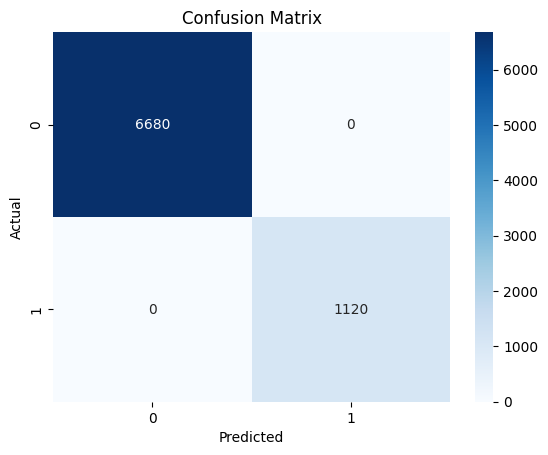

ROC AUC Score: 1.0


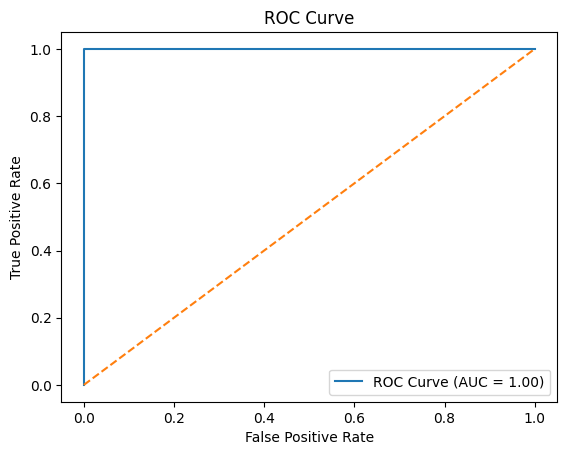

Model saved as random_forest_model.pkl


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Step 1: Load Data and EDA
def load_and_explore_data(file_path):
    data = pd.read_csv(file_path)
    print("Dataset Shape:", data.shape)
    print("Dataset Info:")
    print(data.info())
    print("First 5 Rows:")
    print(data.head())
    print("Missing Values:")
    print(data.isnull().sum())
    # Summary statistics
    print("Summary Statistics:")
    print(data.describe())
    return data

# Step 2: Data Cleaning
def clean_data(data):
    # Rename columns for consistency
    data = data.rename(columns={
        'bulan': 'Bulan',
        ' titik_lokasi': 'Titik_Lokasi',
        ' kecamatan': 'Kecamatan',
        ' wilayah': 'Wilayah',
        ' panjang/luas': 'Luas(m2)',
        'satuan_panjang/luas': 'Satuan_Panjang_Luas',
        'tanggal': 'Tanggal',
        'volume_sampah_perhari(m3)': 'Volume_Sampah_Perhari(m3)'
    })

    # Drop unnecessary columns
    data.drop(['Satuan_Panjang_Luas'], axis=1, inplace=True)

    # Convert numeric columns
    data['Luas(m2)'] = pd.to_numeric(data['Luas(m2)'], errors='coerce')
    data['Volume_Sampah_Perhari(m3)'] = pd.to_numeric(data['Volume_Sampah_Perhari(m3)'], errors='coerce')

    # Handle missing values
    data['Luas(m2)'].fillna(data['Luas(m2)'].mean(), inplace=True)
    data['Volume_Sampah_Perhari(m3)'].fillna(data['Volume_Sampah_Perhari(m3)'].median(), inplace=True)

    # Remove duplicates
    data = data.drop_duplicates()

    # Outlier detection and removal for 'Luas(m2)'
    Q1 = data['Luas(m2)'].quantile(0.25)
    Q3 = data['Luas(m2)'].quantile(0.75)
    IQR = Q3 - Q1
    data = data[~((data['Luas(m2)'] < (Q1 - 1.5 * IQR)) | (data['Luas(m2)'] > (Q3 + 1.5 * IQR)))]

    # Outlier detection and removal for 'Volume_Sampah_Perhari(m3)'
    Q1 = data['Volume_Sampah_Perhari(m3)'].quantile(0.25)
    Q3 = data['Volume_Sampah_Perhari(m3)'].quantile(0.75)
    IQR = Q3 - Q1
    data = data[~((data['Volume_Sampah_Perhari(m3)'] < (Q1 - 1.5 * IQR)) | (data['Volume_Sampah_Perhari(m3)'] > (Q3 + 1.5 * IQR)))]

    # Define target column for demonstration
    data['Class'] = np.where(data['Volume_Sampah_Perhari(m3)'] > data['Volume_Sampah_Perhari(m3)'].median(), 'high', 'low')

    return data

# Step 3: Preprocessing
def preprocess_data(data):
    # Separate features and target
    X = data.drop('Class', axis=1)
    y = data['Class']

    # Encode categorical features
    X = pd.get_dummies(X, drop_first=True)

    # Encode target variable if necessary
    y = y.map({'low': 0, 'high': 1})  # Adjust encoding as needed

    return X, y

# Step 4: Data Split
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

# Step 5: Model Training
def train_random_forest(X_train, y_train):
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    return rf_model

# Step 6: Evaluation and Visualization
def evaluate_model(rf_model, X_test, y_test):
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1] if len(rf_model.classes_) == 2 else None

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print("ROC AUC Score:", roc_auc)

        # ROC Curve
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

# Step 7: Save Model to PKL
def save_model(model, file_name):
    with open(file_name, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved as {file_name}")

# File Path
data_file_path = 'Waste-Collection-Volume.csv'

# Execution
data = load_and_explore_data(data_file_path)
data = clean_data(data)
X, y = preprocess_data(data)
X_train, X_test, y_train, y_test = split_data(X, y)

rf_model = train_random_forest(X_train, y_train)
evaluate_model(rf_model, X_test, y_test)

save_model(rf_model, 'random_forest_model.pkl')